In [1]:
NOTE = 'Ridgeベクトルは除外しPitcherIDでGroupKFold'
notebook_name = '080'
CV = 'GroupK-Fold(pitcherID)'
group_col = 'pitcherID'

In [2]:
import json
import os
import os.path
import pickle
import sys

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns

SCRIPT_PATH = os.path.join('..', 'scripts')
if SCRIPT_PATH not in sys.path:
    sys.path.append(SCRIPT_PATH)
from features import CATEGORICAL_FEATURES, VECTOR_FEATURES

In [3]:
OUTPUT_DIR = os.path.basename(notebook_name)
SUB_FILENAME = notebook_name[:3] + '_submission.csv'
assert(SUB_FILENAME not in pd.read_csv('submissions.csv').filename.tolist())
print(SUB_FILENAME, OUTPUT_DIR)
if not os.path.isdir(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

SEED = 1

# class_weights for CatBoostClassifier, copied from 020
CLASS_WEIGHTS = {
        0: 0.33822833,
        1: 0.4574968, 
        2: 0.71590909,
        3: 1.00280899,
        4: 3.17333333,
        5: 11.45454545,
        6: 194.72727273,
        7: 17.85
    }

080_submission.csv 080


In [4]:
train = pd.read_csv(os.path.join('001_EDA', 'train_data_preprocessed.csv'))
test = pd.read_csv(os.path.join('001_EDA', 'test_data_preprocessed.csv'))

In [5]:
groups = train[group_col]

In [6]:
# Minimal features
minimal_features = [
    'inningNo',
    'totalPitchingCount',
    'B',
    'S',
    'O',
    'b1',
    'b2',
    'b3',
    'numRunners',
    'batterID',
    'pitcherID',
    'Match',
    'isBatterHandLeft',
    'isPitcherHandLeft',
    'isBatterPitcher',
    'isBottom',
    'batterTeam',
    'pitcherTeam',
]

# categorical_features = [f for f in minimal_features if f in CATEGORICAL_FEATURES]
# discrete_features = list(set(minimal_features) - set(categorical_features))
# print(categorical_features)
# print(discrete_features)

# Execute if categories should be one-hot style
## categorical features
for c in CATEGORICAL_FEATURES:
    assert(train[c].isin(test[c]).sum() == train.shape[0])
    assert(test[c].isin(train[c]).sum() == test.shape[0])
train = pd.get_dummies(train, columns=CATEGORICAL_FEATURES, drop_first=True)
test = pd.get_dummies(test, columns=CATEGORICAL_FEATURES, drop_first=True)
assert(set(train.columns.tolist()) - set(test.columns.tolist()) == {'y'})
assert(set(test.columns.tolist()) - set(train.columns.tolist()) == set())
categorical_features = []
for c in CATEGORICAL_FEATURES:
    categorical_features += [c_ for c_ in train.columns if c_.startswith(f'{c}_')]
## vector features
vector_features = VECTOR_FEATURES
## discrete features
discrete_features = [c for c in train.columns
                     if c not in ['y', 'id'] + vector_features + categorical_features]
## all features
features = categorical_features + discrete_features + vector_features

len(categorical_features), len(vector_features), len(discrete_features)

(1857, 384, 107)

In [7]:
categorical_features

['batterID_0',
 'batterID_2',
 'batterID_5',
 'batterID_9',
 'batterID_11',
 'batterID_12',
 'batterID_15',
 'batterID_18',
 'batterID_19',
 'batterID_21',
 'batterID_22',
 'batterID_26',
 'batterID_27',
 'batterID_28',
 'batterID_29',
 'batterID_31',
 'batterID_34',
 'batterID_36',
 'batterID_37',
 'batterID_39',
 'batterID_42',
 'batterID_45',
 'batterID_47',
 'batterID_50',
 'batterID_55',
 'batterID_56',
 'batterID_58',
 'batterID_60',
 'batterID_67',
 'batterID_70',
 'batterID_72',
 'batterID_73',
 'batterID_75',
 'batterID_80',
 'batterID_82',
 'batterID_84',
 'batterID_85',
 'batterID_87',
 'batterID_89',
 'batterID_91',
 'batterID_98',
 'batterID_102',
 'batterID_103',
 'batterID_105',
 'batterID_106',
 'batterID_111',
 'batterID_112',
 'batterID_114',
 'batterID_117',
 'batterID_118',
 'batterID_120',
 'batterID_121',
 'batterID_125',
 'batterID_127',
 'batterID_128',
 'batterID_130',
 'batterID_132',
 'batterID_134',
 'batterID_135',
 'batterID_137',
 'batterID_138',
 'batter

In [8]:
discrete_features

['totalPitchingCount',
 'B',
 'S',
 'O',
 'inningNo',
 'numRunners',
 'pitcherHoursElapsed',
 'pitcherNumGamesParticipated',
 'batterHoursElapsed',
 'batterNumGamesParticipated',
 'speedcount',
 'speedmean',
 'speedstd',
 'speedmin',
 'speed25%',
 'speed50%',
 'speed75%',
 'speedmax',
 'speedrange',
 'speedmeanDiff',
 'speedstdDiff',
 'speedminDiff',
 'speed25%Diff',
 'speed50%Diff',
 'speed75%Diff',
 'speedmaxDiff',
 'pitchTypeRatioカットファストボール',
 'pitchTypeRatioカーブ',
 'pitchTypeRatioシュート',
 'pitchTypeRatioシンカー',
 'pitchTypeRatioストレート',
 'pitchTypeRatioスライダー',
 'pitchTypeRatioチェンジアップ',
 'pitchTypeRatioフォーク',
 'battersFaced',
 'gameIDCount',
 'numInningsSum',
 'inningFromMin',
 'inningFromMean',
 'inningFromMedian',
 'inningFromMax',
 'inningFromStd',
 'inningToMin',
 'inningToMean',
 'inningToMedian',
 'inningToMax',
 'inningToStd',
 'pitcherNumStrikeOuts',
 'pitcherNumWalks',
 'hitsAllowed',
 'K/9',
 'BB/9',
 'K1p/BB1p',
 'whips',
 'pitchersFaced',
 'batterNumStrikeOuts',
 'batterNumWa

In [9]:
vector_features

['ballPositionLabel__no_data__',
 'ど真ん中',
 '内角中心',
 '内角低め',
 '内角高め',
 '外角中心',
 '外角低め',
 '外角高め',
 '真ん中低め',
 '真ん中高め',
 'ballPositionLabeld1',
 'ballPositionLabeld2',
 'ballPositionLabeld3',
 'ballPositionLabeld4',
 'ballPositionLabeld5',
 'ballPositionLabeld6',
 'ballPositionLabeld7',
 'ballPositionLabeld8',
 'ballPositionLabeld9',
 'ballPositionLabeld10',
 'ballPositionLabeld11',
 'ballPositionLabeld12',
 'ballPositionLabeld13',
 'ballPositionLabeld14',
 'ballPositionLabeld15',
 'ballPositionLabeld16',
 'ballPositionLabeld17',
 'ballPositionLabeld18',
 'ballPositionLabeld19',
 'ballPositionLabeld20',
 'ballPositionLabeld21',
 'ballPositionLabeld22',
 'ballPositionLabeld23',
 'ballPositionLabeld24',
 'ballPositionLabeld25',
 'ballPositionLabeld26',
 'ballPositionLabeld27',
 'ballPositionLabeld28',
 'ballPositionLabeld29',
 'ballPositionLabeld30',
 'ballPositionLabeld31',
 'ballPositionLabeld32',
 'ballPositionLabeld33',
 'ballPositionLabeld34',
 'ballPositionLabeld35',
 'ballPositionLabe

In [10]:
# features = [c for c in train.columns if c not in ('id', 'y')]
# assert(set(features) - set(test.columns.tolist()) == set())

In [11]:
# discrete_features = [f for f in features if f not in categorical_features]
# discrete_features

In [12]:
with open(os.path.join('001_EDA', f'group_kfold_{group_col}.json'), 'r') as f:
    fold = json.load(f)
fold

{'0': [120,
  478,
  504,
  607,
  587,
  107,
  136,
  447,
  363,
  2,
  618,
  593,
  616,
  597,
  407,
  48,
  58,
  4,
  394,
  49],
 '1': [311,
  305,
  269,
  143,
  224,
  182,
  267,
  55,
  156,
  550,
  371,
  336,
  575,
  158,
  400,
  211,
  647,
  222,
  493,
  528],
 '2': [130,
  651,
  298,
  448,
  387,
  405,
  634,
  438,
  102,
  245,
  507,
  190,
  147,
  520,
  169,
  210,
  409,
  595,
  494,
  630],
 '3': [247,
  128,
  282,
  185,
  657,
  288,
  459,
  45,
  419,
  16,
  434,
  579,
  596,
  435,
  81,
  334,
  181,
  6,
  467,
  635],
 '4': [348,
  373,
  191,
  101,
  116,
  59,
  383,
  517,
  506,
  350,
  376,
  460,
  35,
  97,
  650,
  119,
  662,
  10,
  359],
 '5': [542,
  241,
  155,
  218,
  196,
  82,
  532,
  524,
  31,
  294,
  110,
  578,
  137,
  476,
  358,
  552,
  262,
  553],
 '6': [483,
  519,
  377,
  395,
  481,
  -1,
  146,
  563,
  29,
  25,
  539,
  114,
  522,
  501,
  474,
  440,
  351,
  275],
 '7': [629,
  365,
  640,
  623,
  

In [13]:
%%time
# splitter = StratifiedKFold(shuffle=True, random_state=SEED, n_splits=N)
cv_pred_dfs = []
pred_dfs = []
metrics = {'train': [], 'valid': []}
models = []
# for i, (train_idx, valid_idx) in enumerate(splitter.split(train, train.y)):
for str_i, ids in fold.items():
    i = int(str_i)
    mask = groups.isin(ids)  # training/validation = False/True
    train_idx, id_train, X_train, y_train, valid_idx, id_valid, X_valid, y_valid = (
        train[~mask].index,
        train[~mask].id,
        train[~mask][features],
        train[~mask].y,
        train[mask].index,
        train[mask].id,
        train[mask][features],
        train[mask].y,
    )
    # feature transformation
    ## categorical features
    X_train_categorical = X_train.copy()[categorical_features]
    X_valid_categorical = X_valid.copy()[categorical_features]
    X_test_categorical = test.copy()[categorical_features]
    ## descrete features
    discrete_transformer = Pipeline(
        steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]
    ).fit(X_train.copy()[discrete_features])
    X_train_discrete = pd.DataFrame(
        data=discrete_transformer.transform(X_train.copy()[discrete_features]),
        columns=discrete_features,
        index=train_idx
    )
    X_valid_discrete = pd.DataFrame(
        data=discrete_transformer.transform(X_valid.copy()[discrete_features]),
        columns=discrete_features,
        index=valid_idx
    )
    X_test_discrete = pd.DataFrame(
        data=discrete_transformer.transform(test.copy()[discrete_features]),
        columns=discrete_features,
        index=test.index
    )
    discrete_transformer.feature_names__ = discrete_features
    discrete_transformer.input_features__ = discrete_features
    with open(os.path.join(OUTPUT_DIR, f'discrete_transformer_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(discrete_transformer, f)
        f.close()
    ## vector features
    """
    vector_transformer = Pipeline(
        steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
            ('decomposer', PCA(n_components=0.8, whiten=True, random_state=SEED))
        ]
    ).fit(X_train.copy()[vector_features])
    columns = [f'pca{i + 1}' for i in range(vector_transformer[-1].n_components_)]
    X_train_vector = pd.DataFrame(
        data=vector_transformer.transform(X_train.copy()[vector_features]),
        columns=columns,
        index=train_idx
    )
    X_valid_vector = pd.DataFrame(
        data=vector_transformer.transform(X_valid.copy()[vector_features]),
        columns=columns,
        index=valid_idx
    )
    X_test_vector = pd.DataFrame(
        data=vector_transformer.transform(test.copy()[vector_features]),
        columns=columns,
        index=test.index
    )
    vector_transformer.feature_names__ = vector_features
    vector_transformer.input_features__ = vector_features
    with open(os.path.join(OUTPUT_DIR, f'vector_transformer_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(vector_transformer, f)
        f.close()
    """
    ## merge
    X_train_transformed = pd.concat([X_train_categorical,
                                     X_train_discrete,
#                                      X_train_vector
                                    ],
                                    axis=1)
    X_train_transformed.to_pickle(
        os.path.join(OUTPUT_DIR, f'train_features_fold{i + 1}.zip'),
        protocol=-1
    )

    X_valid_transformed = pd.concat([X_valid_categorical,
                                     X_valid_discrete,
#                                      X_valid_vector
                                    ],
                                    axis=1)
    X_valid_transformed.to_pickle(
        os.path.join(OUTPUT_DIR, f'valid_features_fold{i + 1}.zip'),
        protocol=-1
    )
    X_test_transformed = pd.concat([X_test_categorical,
                                    X_test_discrete,
#                                     X_test_vector
                                   ],
                                   axis=1)
    X_test_transformed.to_pickle(
        os.path.join(OUTPUT_DIR, f'test_features_fold{i + 1}.zip'),
        protocol=-1
    )
#     class_weight = compute_class_weight('balanced',
#                                         classes=np.sort(train.y.unique()),
#                                         y=y_train.values)
#     class_weight = dict(
#         zip(
#             np.sort(train.y.unique()),
#             class_weight
#         )
#     )
#     sample_weight = y_train.map(class_weight)
#     assert(sample_weight.isnull().sum() == 0)
    sample_weight = None
    # classification    
    clf = RidgeClassifier(max_iter=10000, class_weight='balanced', random_state=SEED)
    clf.fit(X_train_transformed,
            y_train.values,
            sample_weight=sample_weight)
    clf.feature_names__ = X_train_transformed.columns.tolist()
    with open(os.path.join(OUTPUT_DIR, f'model_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(clf, f)
        f.close()
    models.append(clf)
    # Evaluate (trian set)
    pred_train = clf.predict(X_train_transformed)
    
    if pred_train.ndim > 1:
        pred_train = np.squeeze(pred_train)
    pred_train_df = pd.DataFrame(
        {
            'id': id_train,
            'actual': y_train,
            'prediction': pred_train,
        }
    )
    pred_train_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for train set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_train, pred_train))
    print()
    metrics['train'].append(f1_score(y_train, pred_train, average='macro'))
    # Evaluate (valid set)
    pred_valid = clf.predict(X_valid_transformed)
    if pred_valid.ndim > 1:
        pred_valid = np.squeeze(pred_valid)
    pred_valid_df = pd.DataFrame(
        {
            'id': id_valid,
            'actual': y_valid,
            'prediction': pred_valid,
        }
    )
    pred_valid_df['train'] = 1
    print('*' * 10 + f'Confusion matrix for validation set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_valid, pred_valid))
    print()
    metrics['valid'].append(f1_score(y_valid, pred_valid, average='macro'))
    # Save cv result
    cv_pred_df = pd.concat([pred_train_df, pred_valid_df], axis=0)
    cv_pred_df['fold'] = i + 1
    cv_pred_dfs.append(cv_pred_df)
    # Inference
    try:
        infer = clf.predict_proba(X_test_transformed)
    except AttributeError:
        infer = clf.decision_function(X_test_transformed)
    pred_df = pd.DataFrame(
        data=infer,
        columns=clf.classes_
    )
    pred_df['id'] = test.id.values
    pred_df['fold'] = i + 1
    pred_dfs.append(pred_df)


**********Confusion matrix for train set (Fold 1)**********
[[1404  764  602  759  913  632   79  525]
 [ 484 1369  423  492  572  406   62  352]
 [ 226  301  765  393  450  261   34  226]
 [ 130  146  203  846  276  153   25  126]
 [  21   21   20   15  451   42    3   40]
 [   0    0    0    0    0  165    1    6]
 [   0    0    0    0    0    0   10    0]
 [   0    0    0    0    0    0    0  104]]

**********Confusion matrix for validation set (Fold 1)**********
[[182 137  58  68  69  62  12  67]
 [107 155  39  50  49  58   8  56]
 [ 70  62  34  56  38  36   6  34]
 [ 44  32  18  49  29  29   3  27]
 [ 10  14   8  12   8   4   1   5]
 [  5   2   0   4   4   0   0   0]
 [  1   0   0   0   0   0   0   0]
 [  4   2   0   3   5   1   0   1]]

**********Confusion matrix for train set (Fold 2)**********
[[1283  779  603  750  887  621  116  514]
 [ 440 1341  436  502  540  409   76  363]
 [ 203  311  766  362  451  267   50  217]
 [ 133  142  197  813  267  141   42  126]
 [  18   16   1

In [14]:
metrics = pd.DataFrame(metrics).describe()
metrics.to_csv(os.path.join(OUTPUT_DIR, 'metrics.csv'))
metrics

,train,valid
count,10.000000,10.000000
mean,0.264514,0.135354
std,0.002683,0.003810
min,0.261775,0.128993
25%,0.262589,0.132732
50%,0.263535,0.135366
75%,0.265894,0.138238
max,0.269381,0.140631


In [15]:
cv_results = pd.concat(cv_pred_dfs)
cv_results.to_csv(os.path.join(OUTPUT_DIR, 'cross_validation.csv'), index=False)
cv_results

,id,actual,prediction,train,fold
0,0,0,0,0,1
1,1,1,4,0,1
2,2,0,4,0,1
3,3,2,4,0,1
4,4,4,4,0,1
...,...,...,...,...,...
17075,1431,1,4,1,10
17076,1432,0,4,1,10
17077,1433,1,4,1,10
17078,1434,2,4,1,10


In [16]:
submission_ = pd.concat(pred_dfs)
submission_

,0,1,2,3,4,5,6,7,id,fold
0,-0.575460,-0.639929,-0.548435,-0.978196,-0.096126,-0.987391,-1.030497,-1.143965,27446,1
1,-0.855580,-0.820159,0.458909,-0.630970,-1.043265,-0.976905,-1.008544,-1.123487,113,1
2,-0.682595,-0.580212,0.403036,-0.757107,-1.227678,-1.042883,-1.014486,-1.098075,4479,1
3,-0.717249,-0.653365,0.399868,-0.713159,-1.178891,-1.053232,-1.050955,-1.033016,29080,1
4,-0.345320,-0.845917,-0.683130,-0.788565,-1.169297,0.103156,-1.060389,-1.210537,19319,1
...,...,...,...,...,...,...,...,...,...,...
33803,-0.786288,-0.455887,-0.608556,-0.337704,-0.930373,-1.013964,-0.960254,-0.906974,24272,10
33804,-0.810436,-0.917357,-0.657488,-0.466722,-0.584549,-0.913476,-0.877029,-0.772943,29106,10
33805,-0.988477,-0.957692,-0.618795,-0.382740,-0.616804,-0.870708,-0.983776,-0.581007,20679,10
33806,-0.561326,-1.008359,-0.671140,-0.371982,-0.536750,-1.053208,-0.855469,-0.941766,25901,10


In [17]:
submission_ = submission_.groupby('id')[[0, 1, 2, 3, 4, 5, 6, 7]].sum().sort_index().reset_index()
submission_

,id,0,1,2,3,4,5,6,7
0,0,-5.911217,-3.861181,-5.731549,-3.165322,-7.799569,-10.559586,-10.964009,-12.007567
1,1,-5.070024,-3.457602,-6.800704,-5.261964,-12.842448,-6.050282,-9.556887,-10.960089
2,2,-11.508292,-7.937196,-5.764074,-3.986890,1.019357,-9.022008,-11.345339,-11.455558
3,3,-3.184830,-4.666152,-8.524179,-6.406730,-9.566238,-9.940962,-10.216018,-7.494889
4,4,-7.647774,-2.326601,-10.175526,-6.731773,-0.435427,-12.226615,-9.720851,-10.735432
...,...,...,...,...,...,...,...,...,...
33803,33803,-3.854319,-6.126070,-4.756125,-9.810566,-6.657062,-12.074638,-9.123328,-7.597892
33804,33804,-4.156251,-6.751156,-7.803562,-3.986171,-6.828590,-11.358295,-11.245037,-7.870938
33805,33805,-4.535124,-8.501705,-9.080966,-5.200310,-6.584540,-8.296846,-10.391449,-7.409058
33806,33806,-12.862354,-6.915963,-5.957216,-3.572630,-4.546643,-5.193521,-9.809504,-11.142169


In [18]:
submission = pd.DataFrame(
    {
        'id': submission_.id,
        'y' : np.argmax(submission_[[0, 1, 2, 3, 4, 5, 6, 7]].values, axis=1)
    }
)
submission

,id,y
0,0,3
1,1,1
2,2,4
3,3,0
4,4,4
...,...,...
33803,33803,0
33804,33804,3
33805,33805,0
33806,33806,3


0    0.369573
1    0.273226
2    0.174603
3    0.124650
4    0.039391
5    0.010913
6    0.000642
7    0.007003
Name: y, dtype: float64

0    0.179129
1    0.180372
2    0.070605
3    0.203827
4    0.131004
5    0.081874
6    0.018575
7    0.134613
Name: y, dtype: float64

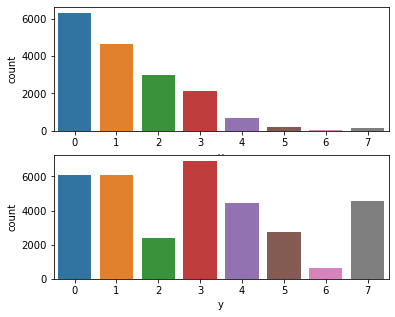

In [19]:
fig = plt.figure(figsize=(6., 5.))
fig.add_subplot(2, 1, 1)
sns.countplot(data=train, x='y')
fig.add_subplot(2, 1, 2)
sns.countplot(data=submission, x='y')
display(train.y.value_counts(normalize=True).sort_index())
display(submission.y.value_counts(normalize=True).sort_index())

In [20]:
submission.to_csv(os.path.join(OUTPUT_DIR, SUB_FILENAME), index=False)

In [21]:
metrics.loc['mean', 'train'], metrics.loc['mean', 'valid']

(0.2645144549322907, 0.13535443155330912)

In [22]:
print('"{}","{}","{:.6f}","{:.6f}","","{}"'.format(SUB_FILENAME, CV, metrics.loc['mean', 'train'], metrics.loc['mean', 'valid'], NOTE))

"080_submission.csv","GroupK-Fold(pitcherID)","0.264514","0.135354","","Ridgeベクトルは除外しPitcherIDでGroupKFold"


In [23]:
%%time
imp_df = pd.DataFrame()
for i, final_estimator in enumerate(models):
    try:
        if hasattr(final_estimator, 'feature_importances_'):
            feature_importance = final_estimator.feature_importances_
        else:
            feature_importance = final_estimator.final_estimator.get_feature_importance()
            
        if hasattr(final_estimator, 'feature_name_'):
            feature_names = final_estimator.feature_name_
        elif hasattr(final_estimator, 'feature_names_'):
            feature_names = final_estimator.feature_names_
        else:
            feature_names = final_estimator.get_booster().feature_names
        imp_df_ = pd.DataFrame(
            {
                'feature': feature_names,
                'importance': feature_importance
            }
        )
        imp_df_['fold'] = i + 1
        imp_df = pd.concat([imp_df, imp_df_])
    except AttributeError:
        pass

if imp_df.shape[0] > 0:
    imp_df.to_csv(os.path.join(OUTPUT_DIR, 'feature_importances.csv'), index=False)

Wall time: 0 ns


In [24]:
imp_df

""


In [25]:
%%time
coef_df = pd.DataFrame()
for i, final_estimator in enumerate(models):
    try:
        if hasattr(final_estimator, 'coef_'):
            coefficient = final_estimator.coef_
            coef_df_ = pd.DataFrame(coefficient, columns=final_estimator.feature_names__)
            coef_df_['fold'] = i + 1
            coef_df_['y'] = final_estimator.classes_
            coef_df = pd.concat([coef_df, coef_df_])
    except AttributeError:
        pass

if coef_df.shape[0] > 0:
    coef_df.to_csv(os.path.join(OUTPUT_DIR, 'coefficients.csv'), index=False)

Wall time: 203 ms


In [26]:
coef_df

,batterID_0,batterID_2,batterID_5,batterID_9,batterID_11,batterID_12,batterID_15,batterID_18,batterID_19,batterID_21,...,distDirS,distDirT,distDirU,distDirV,distDirW,distDirX,distDirY,distDirZ,fold,y
0,0.134568,-0.141993,0.065043,0.012532,0.130588,-0.019420,0.173355,-0.049127,-0.213199,0.260943,...,0.000795,0.011034,-0.000471,0.009463,-0.014320,-0.027956,-0.012783,0.001938,1,0
1,0.012944,0.336765,-0.314750,0.147418,0.019100,-0.083305,-0.000344,-0.175514,-0.246830,-0.173867,...,0.006218,0.005236,0.041725,-0.014731,0.001116,0.018386,0.013303,0.013734,1,1
2,0.191837,-0.074718,-0.127566,0.039862,0.063817,0.146174,-0.066107,-0.016809,-0.177797,-0.035889,...,-0.010035,0.012617,0.019151,-0.026343,0.016090,0.025296,0.018261,0.031981,1,2
3,-0.044563,-0.000543,0.028336,0.099273,-0.060704,-0.168706,0.100913,-0.184837,0.023715,-0.072193,...,0.018770,0.020575,-0.028275,0.034379,0.022927,-0.038854,0.019128,-0.005458,1,3
4,0.225925,-0.315821,-0.140218,0.057986,0.014371,0.023056,-0.039987,0.023161,0.265135,-0.063341,...,0.007746,0.008008,-0.035739,-0.018427,-0.006908,-0.010889,-0.014011,-0.039079,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,-0.069415,-0.028176,0.058371,0.007044,-0.106341,-0.068491,0.120212,-0.127135,0.027317,-0.134500,...,0.025771,0.012997,-0.047562,0.006392,0.037031,-0.049716,0.034546,-0.009825,10,3
4,0.102422,-0.356545,-0.097530,0.220293,0.053814,-0.030806,0.029033,-0.089832,0.302067,-0.093574,...,-0.007147,-0.000765,-0.024335,0.000834,-0.002777,-0.001882,-0.013395,-0.034032,10,4
5,-0.383546,0.062100,-0.216122,-0.077402,-0.052100,0.137009,0.216024,0.036772,-0.140606,0.285644,...,0.014930,0.018411,0.009905,0.004728,-0.033268,0.039183,-0.013621,0.016649,10,5
6,-0.078219,0.124029,0.003104,0.008392,-0.147470,0.038428,0.078595,0.110146,0.557072,0.040224,...,-0.012396,-0.040134,0.048828,-0.019777,-0.022912,0.022713,-0.007152,-0.017387,10,6
